In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import pandas as pd

from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler 
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import *

In [2]:
# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "2g")
    .config("spark.executer.memory", "4g")
    .getOrCreate()
)

22/09/26 17:35:35 WARN Utils: Your hostname, Luo resolves to a loopback address: 127.0.1.1; using 172.27.92.55 instead (on interface eth0)
22/09/26 17:35:35 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/09/26 17:35:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/09/26 17:35:37 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
full = spark.read.parquet('../data/curated/train_data/')
full = full.withColumnRenamed('y_total_num_consumer', 'next_total_num_consumer').withColumnRenamed('y_total_revenue', 'next_total_revenue')\
    .withColumnRenamed('y_total_num_transaction', 'next_total_num_transaction')
full.printSchema()

root
 |-- merchant_abn: long (nullable = true)
 |-- total_num_consumer: long (nullable = true)
 |-- avg_dollar_value: double (nullable = true)
 |-- total_num_transaction: long (nullable = true)
 |-- mean_income: double (nullable = true)
 |-- revenue_level: string (nullable = true)
 |-- total_revenue: double (nullable = true)
 |-- total_num_postcode: long (nullable = true)
 |-- tag: string (nullable = true)
 |-- next_total_num_consumer: long (nullable = true)
 |-- next_total_revenue: double (nullable = true)
 |-- next_total_num_transaction: long (nullable = true)



In [4]:
tag_mean = full.groupBy('tag')\
      .agg(
         F.mean("total_revenue").alias("mean_revenue_of_tags")
      )

In [5]:
tag_mean = tag_mean.toPandas()

In [6]:
from sklearn.cluster import KMeans
import numpy as np

kmeans = KMeans(n_clusters=4, random_state=0).fit(np.array(tag_mean['mean_revenue_of_tags']).reshape(-1, 1))
kmeans.labels_

array([2, 0, 0, 1, 2, 0, 3, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 2, 2, 1, 1, 2,
       1, 0], dtype=int32)

In [7]:
tag_mean['tag_labels'] = kmeans.labels_
tag_mean

,tag,mean_revenue_of_tags,tag_labels
0,jewelry,301542.063851,2
1,watch,565603.630545,0
2,cable,545919.891131,0
3,garden supply,732549.584612,1
4,antique,431668.237726,2
5,shoe,534436.300789,0
6,tent,995172.851759,3
7,stationery,518011.067448,0
8,artist supply,719151.356147,1
9,florists,637021.720045,1


In [8]:
tag_mean_sdf = spark.createDataFrame(tag_mean[['tag', 'tag_labels']])
tag_mean_sdf

tag,tag_labels
jewelry,2
watch,0
cable,0
garden supply,1
antique,2
shoe,0
tent,3
stationery,0
artist supply,1
florists,1


In [9]:
full = full.join(tag_mean_sdf, ["tag"], how="left") 
# use left join here since if no historical data is provided, we cannot predict the future value of a merchant
full

tag,merchant_abn,total_num_consumer,avg_dollar_value,total_num_transaction,mean_income,revenue_level,total_revenue,total_num_postcode,next_total_num_consumer,next_total_revenue,next_total_num_transaction,tag_labels
jewelry,10596295795,8,10439.40181102842,8,61840.875,a,571244.0798428855,8,null,null,null,2
watch,10187291046,87,111.08408713922158,87,61060.0459770115,b,31795.597893195016,87,99,41683.211213258364,100,0
watch,10264435225,1238,114.10783402533235,1272,62006.311320754714,c,346896.9592900661,1018,1519,435003.6795629895,1566,0
watch,10922217544,18,163.5626661571798,18,63804.22222222222,c,4946.134870167458,18,19,5880.61894060871,19,0
shoe,10955677986,196,224.31663343377568,197,62081.20304568528,a,249233.71917554762,191,232,311007.83981679846,235,0
tent,10651113986,17,537.592173774402,17,57981.94117647059,b,29701.967601035707,17,24,40997.390332967654,24,3
stationery,10618089367,903,382.6779937277748,919,63214.549510337325,b,1410241.1961990686,783,994,1427868.1901742313,1011,0
artist supply,10463252268,22,464.0964976850653,22,60070.77272727273,a,67488.91405656068,22,26,78474.65405470507,26,1
florists,10545955006,108,475.27264003873785,108,63127.56481481482,a,316189.37413271976,106,133,359500.80479674053,133,1
music,10364012396,4,276.08689369891994,4,81123.75,b,4008.7818228908673,4,16,19636.790814026932,16,0


In [24]:
# drop the columns not needed
consumer_df = full.drop('merchant_abn', 'avg_dollar_value', 'mean_income', 'revenue_level', 'total_revenue', 'total_num_postcode', 'tag_labels', 'next_total_revenue', 'next_total_num_transaction')
consumer_df

tag,total_num_consumer,total_num_transaction,next_total_num_consumer
jewelry,8,8,null
watch,87,87,99
watch,1238,1272,1519
watch,18,18,19
shoe,196,197,232
tent,17,17,24
stationery,903,919,994
artist supply,22,22,26
florists,108,108,133
music,4,4,16


In [25]:
# change tags into numeric feature by one hot encoding
indexer = StringIndexer(inputCol="tag", outputCol="tagIndex")
consumer_df = indexer.fit(consumer_df).transform(consumer_df)
ohe = OneHotEncoder(inputCol="tagIndex", outputCol="tagOHE")
consumer_df = ohe.fit(consumer_df).transform(consumer_df)
consumer_df

tag,total_num_consumer,total_num_transaction,next_total_num_consumer,tagIndex,tagOHE
jewelry,8,8,null,23.0,"(23,[],[])"
jewelry,1,1,null,23.0,"(23,[],[])"
jewelry,2,2,null,23.0,"(23,[],[])"
jewelry,1,1,null,23.0,"(23,[],[])"
jewelry,33,33,4,23.0,"(23,[],[])"
jewelry,29,29,null,23.0,"(23,[],[])"
jewelry,3,3,1,23.0,"(23,[],[])"
jewelry,1,1,null,23.0,"(23,[],[])"
jewelry,5,5,1,23.0,"(23,[],[])"
jewelry,3,3,null,23.0,"(23,[],[])"


In [26]:
import six
for i in consumer_df.columns[:-1]:
    if not( isinstance(consumer_df.select(i).take(1)[0][0], six.string_types)):
        print( "Correlation to next_total_num_consumer for ", i, consumer_df.stat.corr('next_total_num_consumer',i))

Correlation to next_total_num_consumer for  total_num_consumer 0.9981035681655714
Correlation to next_total_num_consumer for  total_num_transaction 0.9034771303928175
Correlation to next_total_num_consumer for  next_total_num_consumer 1.0
Correlation to next_total_num_consumer for  tagIndex -0.1440912852559996


In [28]:
features = ['total_num_consumer', 'total_num_transaction']
assembler = VectorAssembler(inputCols=features, outputCol='features')
final_consumer_df = assembler.transform(consumer_df)
final_consumer_df = final_consumer_df.select('features','next_total_num_consumer')
final_consumer_df

features,next_total_num_consumer
"[8.0,8.0]",null
"[1.0,1.0]",null
"[2.0,2.0]",null
"[1.0,1.0]",null
"[33.0,33.0]",4
"[29.0,29.0]",null
"[3.0,3.0]",1
"[1.0,1.0]",null
"[5.0,5.0]",1
"[3.0,3.0]",null


In [29]:
# missing values will not be included
train_df, test_df = (final_consumer_df.drop('tag', 'tagIndex').filter(F.col('next_total_num_consumer').isNotNull())).randomSplit([0.7, 0.3])
train_df.count(), test_df.count()

(2645, 1139)

In [30]:
lr = LinearRegression(labelCol='next_total_num_consumer', maxIter=10, regParam=0.3, elasticNetParam=0.8)
fitted_model = lr.fit(train_df)
fitted_model.setFeaturesCol("features")
fitted_model.setPredictionCol("prediction")

LinearRegressionModel: uid=LinearRegression_d52b5e2c888d, numFeatures=2

In [31]:
print("Coefficients: %s" % str(fitted_model.coefficients))
print("Intercept: %s" % str(fitted_model.intercept))


Coefficients: [1.249516514785597,-0.07795596134254693]
Intercept: -0.8330669110735723


In [32]:
trainingSummary = fitted_model.summary
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

numIterations: 10
objectiveHistory: [0.5, 0.3694870063605562, 0.11297669991769309, 0.024638589797131703, 0.020646352018943513, 0.008167354338343159, 0.0009658887993414882, 0.0008998241089019962, 0.0007109247200358449, 0.0007108940467781348, 0.0007108940450385354]
+-------------------+
|          residuals|
+-------------------+
| 0.6615063576305221|
| 0.6615063576305221|
| 0.6615063576305221|
| 0.6615063576305221|
| 0.6615063576305221|
| 0.6615063576305221|
| 0.6615063576305221|
| 0.6615063576305221|
| 0.6615063576305221|
| 1.6615063576305222|
| 2.6615063576305222|
| 2.6615063576305222|
| 2.6615063576305222|
| 3.6615063576305222|
| 3.6615063576305222|
|  4.661506357630522|
|-0.5100541958125282|
|-0.5100541958125282|
|-0.5100541958125282|
|-0.5100541958125282|
+-------------------+
only showing top 20 rows

RMSE: 64.885139
r2: 0.998921


In [33]:
lr_predictions = fitted_model.transform(test_df)
lr_predictions.select("prediction","next_total_num_consumer","features").show(10)
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="next_total_num_consumer",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+------------------+-----------------------+---------+
|        prediction|next_total_num_consumer| features|
+------------------+-----------------------+---------+
|0.3384936423694779|                      1|[1.0,1.0]|
|0.3384936423694779|                      1|[1.0,1.0]|
|0.3384936423694779|                      1|[1.0,1.0]|
|0.3384936423694779|                      1|[1.0,1.0]|
|0.3384936423694779|                      1|[1.0,1.0]|
|0.3384936423694779|                      2|[1.0,1.0]|
|1.5100541958125282|                      1|[2.0,2.0]|
|1.5100541958125282|                      1|[2.0,2.0]|
|1.5100541958125282|                      1|[2.0,2.0]|
|1.5100541958125282|                      3|[2.0,2.0]|
+------------------+-----------------------+---------+
only showing top 10 rows

R Squared (R2) on test data = 0.999127


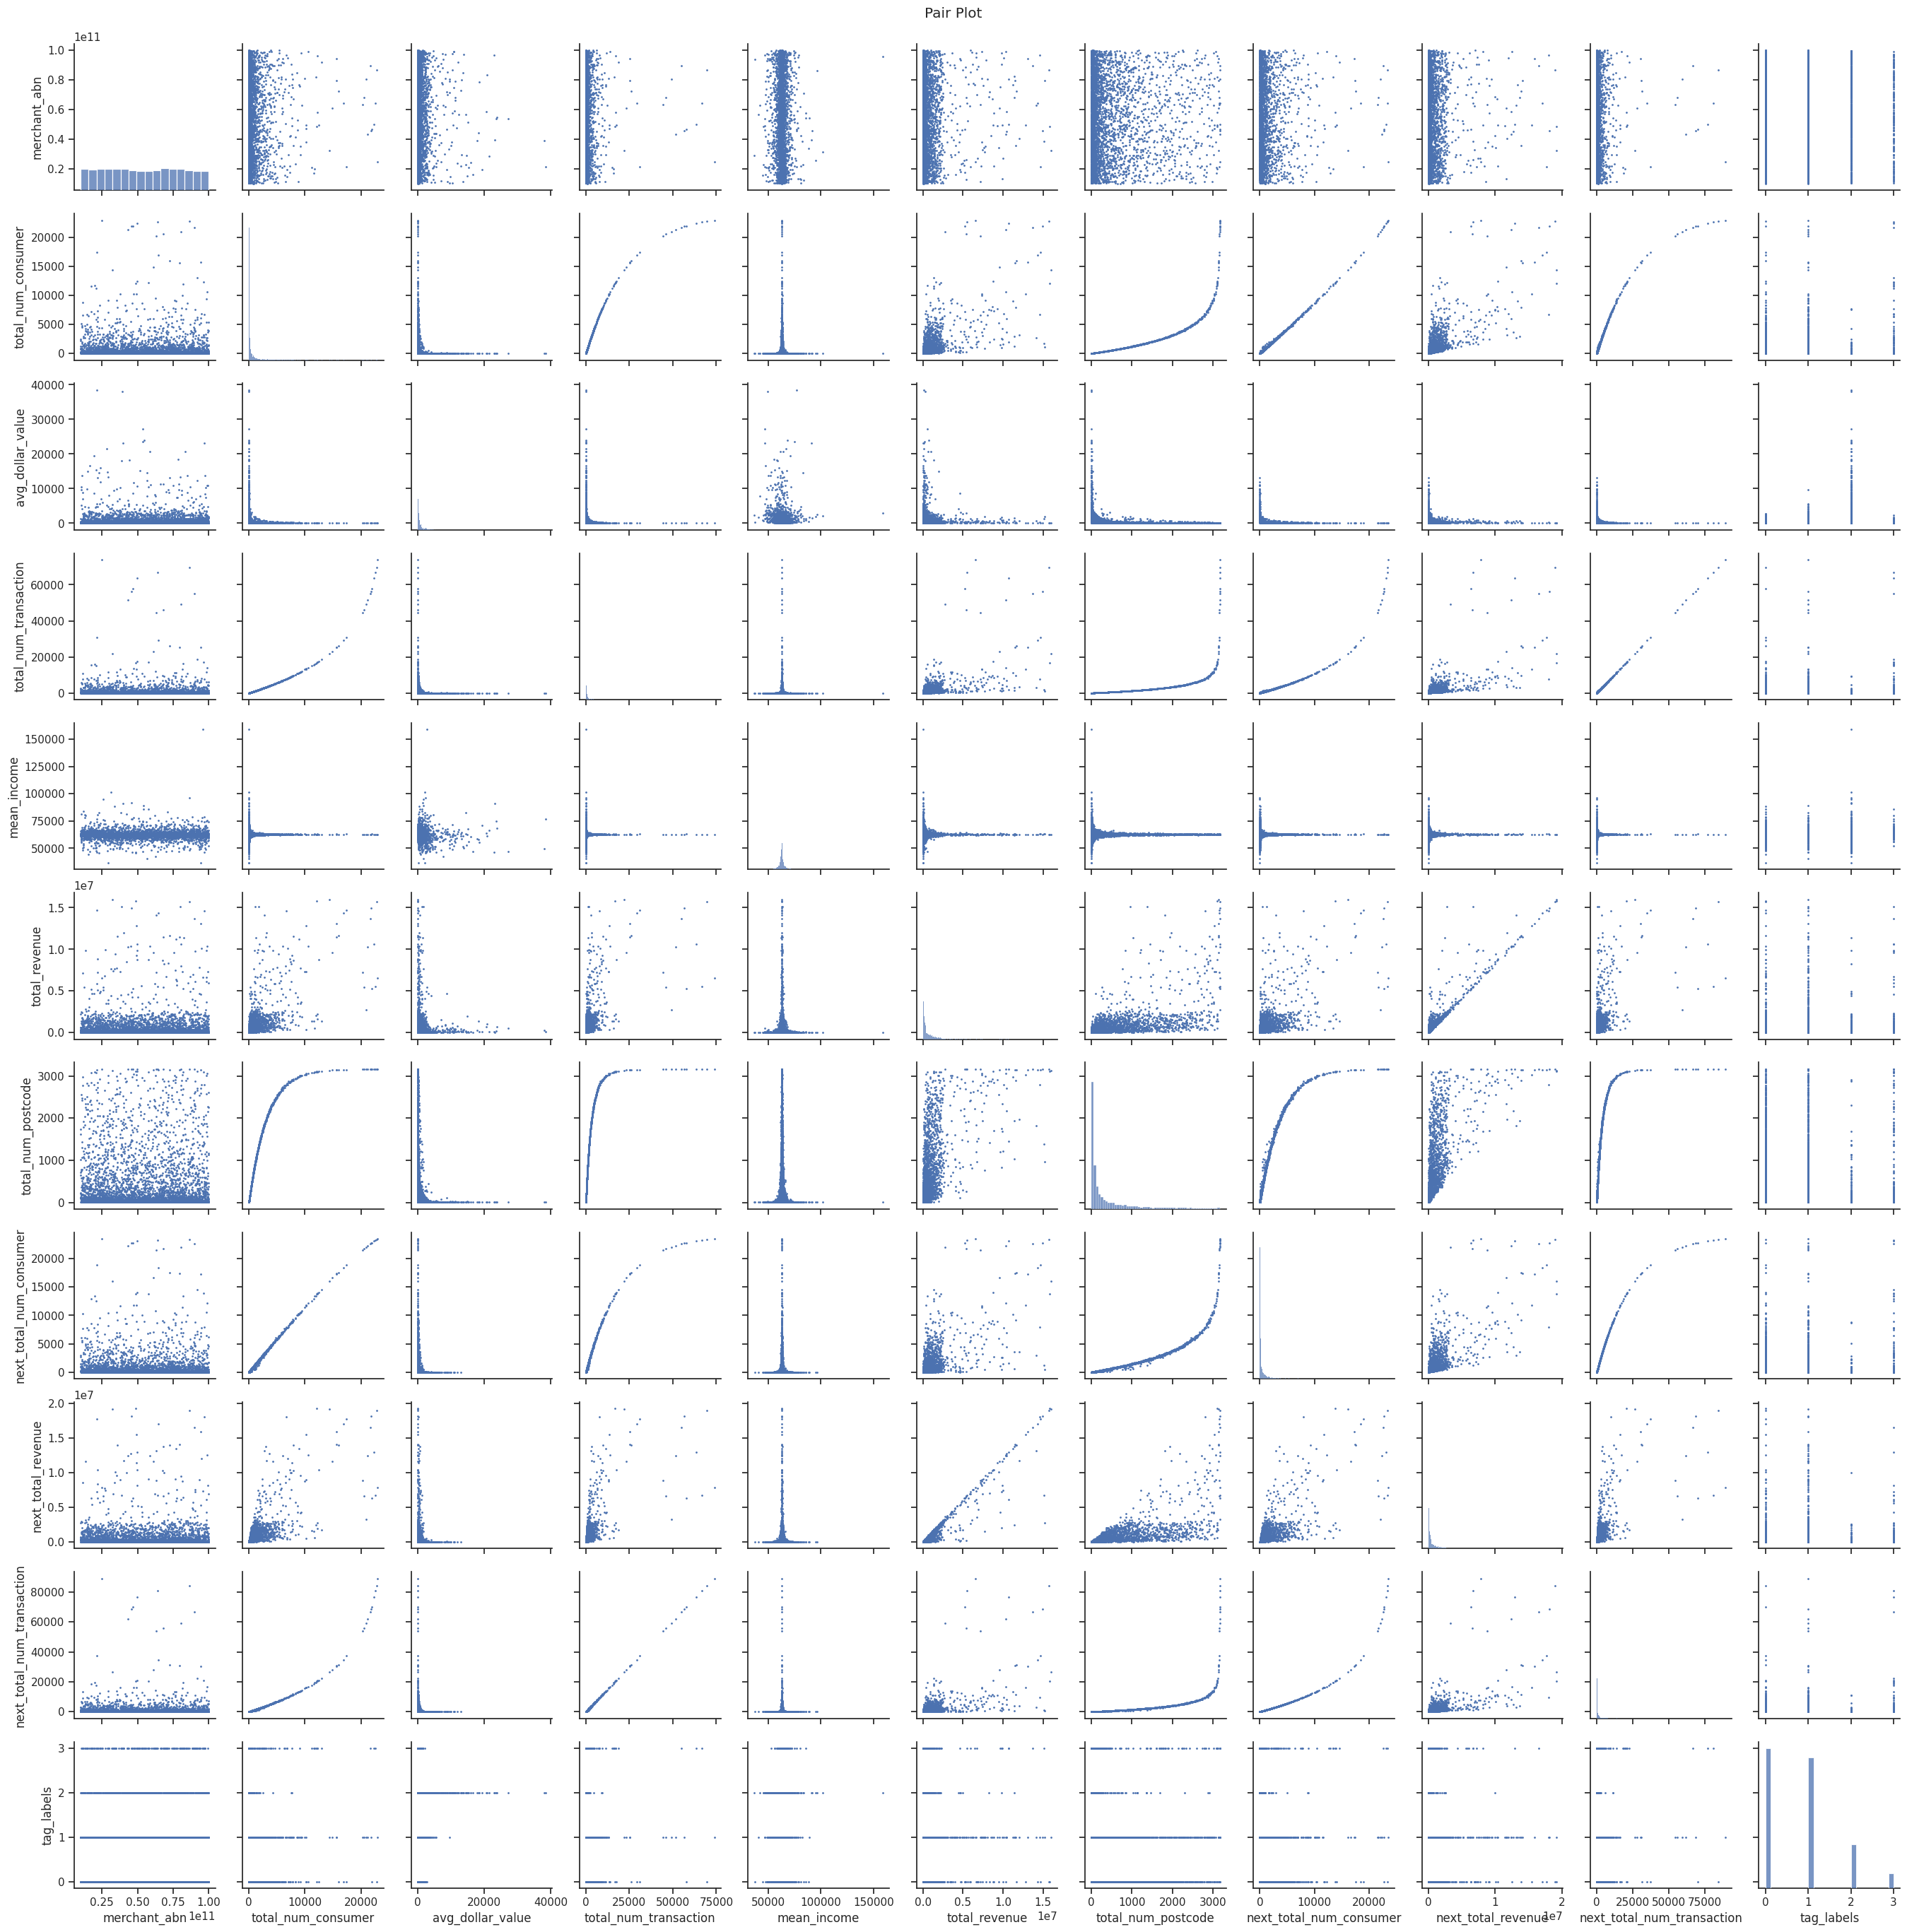

In [22]:
import seaborn as sbs
import matplotlib.pyplot as plt

full_df = full.toPandas()

sbs.set(style="ticks", color_codes=True)
g = sbs.pairplot(full_df, plot_kws=dict(s=1, edgecolor="b", linewidth=1),)
g.fig.suptitle("Pair Plot", y = 1)
g.fig.savefig("../plots/Pair Plot for all features.jpg")
plt.show()